# AndroR Fingerprint Based Clustering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import utils
import ml

In [2]:
andror_df_all = pd.read_csv("../AndroR_4_final_dataset_training_ALL_STD_rdkit.csv", index_col=0)
andror_df_pub= pd.read_csv("../AndroR_4_final_dataset_training_PUB_STD_rdkit.csv", index_col=0)

In [3]:
# get internal compounds by checking whether Compound No is availabe in pub

andror_df_secret = andror_df_all[~andror_df_all["Compound No"].isin(andror_df_pub["Compound No"])]
andror_df_pub = andror_df_all[andror_df_all["Compound No"].isin(andror_df_pub["Compound No"])]

In [4]:
print(len(andror_df_pub))
print(len(andror_df_secret))

24948
47738


## Cluster All HTS data

In [7]:
fps = utils.get_fingerprints(andror_df_all)

Generating the 0.00 Tanimoto threshold clusters is trivial: each molecule is its own cluster.

In [13]:
andror_df_all["cluster_000"] = andror_df_all.index

Determining the cluster is time consuming.
Especially for the lower Tanimoto thresholds, this can take >20 minutes.

In [8]:
andror_df_all["cluster_035"] = utils.get_cluster_assignments_from_fps(fps, 0.35, chunk_size=5000)

In [9]:
andror_df_all["cluster_045"] = utils.get_cluster_assignments_from_fps(fps, 0.45, chunk_size=5000)

In [10]:
andror_df_all["cluster_065"] = utils.get_cluster_assignments_from_fps(fps, 0.65, chunk_size=5000)

For convenience, save pd.DataFrame including cluster assignments to disc so they can be reused.

In [ ]:
# andror_df_all.drop(['Unnamed: 0'], axis=1).to_csv("../andror_df_all_clusters.csv")

In [16]:
for col in ["cluster_000", "cluster_035", "cluster_045", "cluster_065"]:
    print(col, len(andror_df_all[col].unique()))

cluster_000 72686
cluster_035 59585
cluster_045 44499
cluster_065 16917


# Compare Performance Depending on Tanimoto Threshold

In [5]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

In [6]:
andror_df_all = utils.add_fingerprints_to_df(andror_df_all)

In [7]:
splits_000, pipelines_000 = ml.run_or_retrieve_from_disc(
    X=andror_df_all[utils.FP_COLUMNS], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_000"], 
    training_name="tanimoto_000",
)

Repetitions: 100%|██████████| 5/5 [1:17:41<00:00, 932.30s/it] 


In [8]:
splits_035, pipelines_035 = ml.run_or_retrieve_from_disc(
    X=andror_df_all[utils.FP_COLUMNS], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_035"], 
    training_name="tanimoto_035",
)

Repetitions: 100%|██████████| 5/5 [1:22:19<00:00, 987.86s/it]


In [10]:
splits_045, pipelines_045 = ml.run_or_retrieve_from_disc(
    X=andror_df_all[utils.FP_COLUMNS], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_045"], 
    training_name="tanimoto_045",
)

In [13]:
splits_065, pipelines_065 = ml.run_or_retrieve_from_disc(
    X=andror_df_all[utils.FP_COLUMNS], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_065"], 
    training_name="tanimoto_065",
)

In [11]:
from analysis import CV

In [14]:
CV_000 = CV(splits_000)
CV_035 = CV(splits_035)
CV_045 = CV(splits_045)
CV_065 = CV(splits_065)

Plot ROC Curves

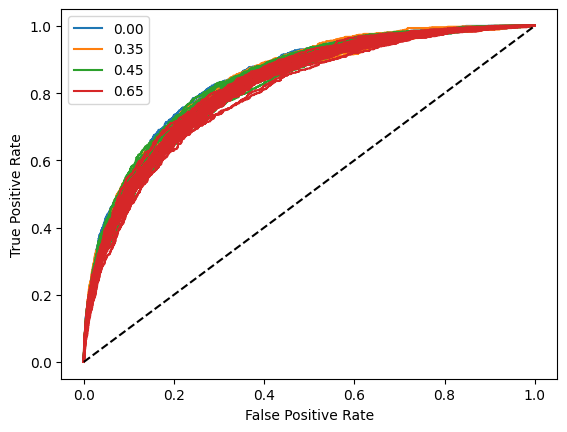

In [18]:
# get color cycle from matplotlib
import matplotlib.cm as cm
import itertools
from sklearn.metrics import roc_curve

colors = cm.tab10.colors
color_cycle = itertools.cycle(colors)

for curr_tanimoto_threshold, curr_CV in {
    0.00: CV_000,
    0.35: CV_035, 
    0.45: CV_045, 
    0.65: CV_065,
    }.items():
    color = next(color_cycle)
    for idx, fold in enumerate(curr_CV.folds):
        fpr, tpr, thresholds = roc_curve(fold.y, fold.y_hat_proba[:,1], pos_label="inhibitor")
        ba_by_threshold = pd.Series((tpr + (1 - fpr)) / 2, index=thresholds)
        if idx == 0:
            curr_label = f"{curr_tanimoto_threshold:.2f}"
        else:
            curr_label = None
        plt.plot(fpr, tpr, label=curr_label, color=color)


plt.plot([0, 1], [0, 1], linestyle="--", c="k")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# add legend but only for every fifth entry

plt.legend()
# plt.ylim(0.45, 1.05)